Dieses Notebook ist eine Überarbeitung einer Ausarbeitung des Studierenden Patrick Benz.

# Clustering mit k-Means - R-Beispiel
> Dieses Beispiel folgt einem k-Means-Beispiel, welches [hier](https://rpubs.com/Nitika/kmeans_Iris) seitens [RStudio](https://www.rstudio.com/) bereit gestellt wird. Wir nutzen dabei den in R mitgelieferten Datensatz `iris` (siehe auch die Unterrichtsübung). Der Datensatz enthält Einträge über Schwertlilien. Diese sollen dann mit Hilfe des k-Means-Algorithmus bestimmten Clustern zugeordnet werden.

Zu Beginn sollte das später benötigte Paket `factoextra` installiert und die entsprechende Bibliothek eingebunden werden. Diese dient später als nützliches Hilfsmittel zur graphischen Darstellung.

In [1]:
# install.packages("factoextra", dependencies=FALSE) -- funktioniert nicht
# Daher:
# conda config --add channels conda-forge
# conda install r-factoextra

In [2]:
library(factoextra)

Loading required package: ggplot2
Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


Im nächsten Schritt wird der zugehörige Standarddatensatz `iris` aus R geladen.

In [3]:
require("datasets")
data("iris")

Nun kann die Struktur des Datensatzes betrachtet werden.

In [4]:
str(iris)

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


Man erkennt, dass 150 Einträge vorliegen. Diese haben jeweils 5 Variablen (jeweils die Sepal/Petal, Länge/Breite, sowie drei die Spezies *setosa*, *versicolor* und *virginica*)

![Sepal und Petal](images/petal_sepal_label.png)

In [5]:
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


Da wir die Klassenlabels für unüberwachtes Lernen und unseren Algorithmus nicht benötigen, werden diese nun entfernt und in `iris.class` gespeichert (die Klassenlabels verwenden wir später bei der *Klassifikation*).

In [6]:
iris.new <- iris[,c(1,2,3,4)]
iris.class <- iris[,"Species"]
head(iris.new)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
5.1,3.5,1.4,0.2
4.9,3.0,1.4,0.2
4.7,3.2,1.3,0.2
4.6,3.1,1.5,0.2
5.0,3.6,1.4,0.2
5.4,3.9,1.7,0.4


### Visualisierung zum Datenverständnis
Wir schauen uns zunächst die Scatterplots der paarweise zusammengestellten Features an.

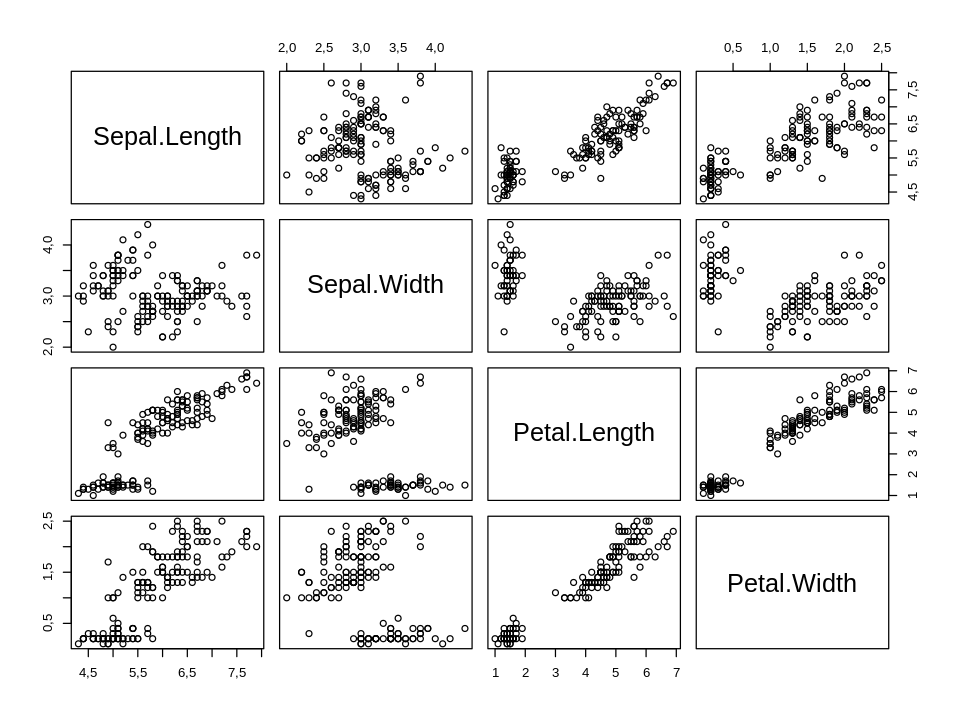

In [7]:
options(repr.plot.width=8, repr.plot.height=6)
plot(iris.new)

Man sieht deutlich, dass die Länge des Petalbaltts eine wichtige Rolle spielt bei der Aufteilung in Cluster. Schauen wir nun einfach nur das Petalblatt an.

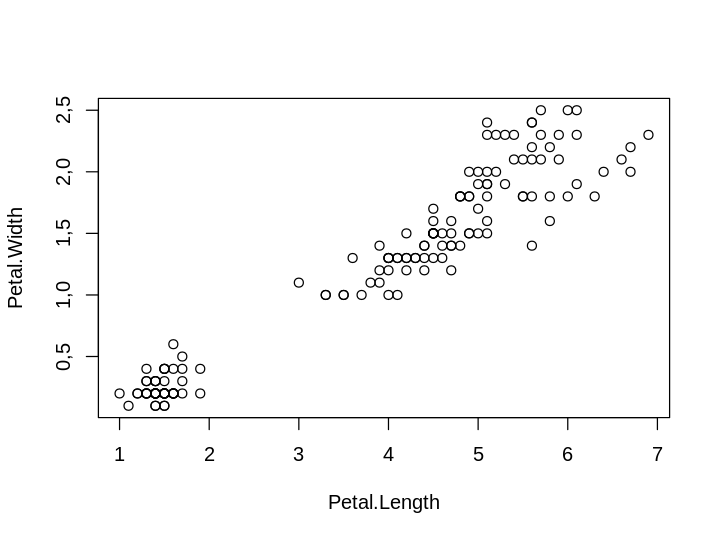

In [8]:
options(repr.plot.width=6, repr.plot.height=4.5)
plot(iris.new[,c(3,4)])

Es scheint, als benötige man 2 oder 3 Cluster für die Iris-Daten. Dies werden wir nun prüfen.

### Vorbereitung

Im Folgenden normalisieren wir die Werte der Attribute auf 0 bis 1, mit einer selbst erstellten Funktion. Diese Funktion nutzt dabei die Min- und Max-Werte eines Merkmals, um alle Merkmalswerte auf ein selbes Maß zu skalieren (siehe dazu dann die vorbereitende Aufgabe des Miniprojekts).

In [9]:
normalize <- function(x){
  return ((x-min(x))/(max(x)-min(x)))
}

iris.new$Sepal.Length <- normalize(iris.new$Sepal.Length)
iris.new$Sepal.Width <- normalize(iris.new$Sepal.Width)
iris.new$Petal.Length <- normalize(iris.new$Petal.Length)
iris.new$Petal.Width <- normalize(iris.new$Petal.Width)
head(iris.new)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
"0,22222222","0,6250000","0,06779661","0,04166667"
"0,16666667","0,4166667","0,06779661","0,04166667"
"0,11111111","0,5000000","0,05084746","0,04166667"
"0,08333333","0,4583333","0,08474576","0,04166667"
"0,19444444","0,6666667","0,06779661","0,04166667"
"0,30555556","0,7916667","0,11864407","0,12500000"


Nun sind die Daten richtig vorbereitet und wir können wieder den Ellenbogenpunkt suchen. Hierfür verwenden wir die Funktion [`fviz_nbclust`](https://www.rdocumentation.org/packages/factoextra/versions/1.0.5/topics/fviz_nbclust) aus dem vorher eingebundenen Paket `factoextra`, um den Ellenbogenpunkt und die optimale Anzahl an Clustern graphisch ablesen zu können.

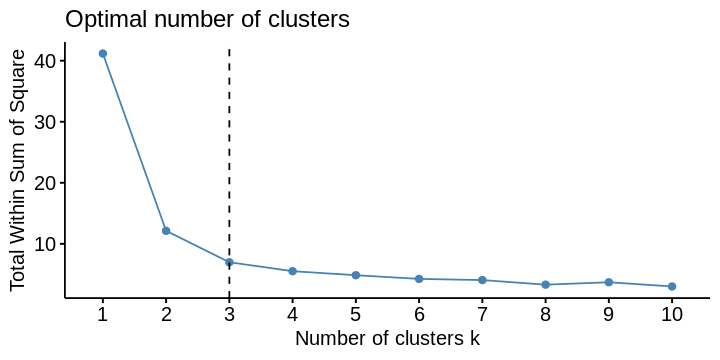

In [10]:
options(repr.plot.width=6, repr.plot.height=3)
fviz_nbclust(iris.new, kmeans, method = "wss")+ 
geom_vline(xintercept = 3, linetype = 2)

Wie bereits zuvor vermutet, scheint $k = 2$ oder $k = 3$ die richtige Wahl zu sein. Da die Verbesserung von 2 zu 3 durchaus noch deutlich ausfällt, spricht das für die Wahl von $k = 3$.

Interessanter Weise lässt sich mit Hilfe von `fviz_nbclust` auch durch Verwendung der Methode `silhouette` anstelle von `wss` ein gut geeignetes $k$ mit Hilfe des *durchschnittlichen Silhouettewerts* bestimmen (in der erzeugten Grafik wird dieses sogar automatisch durch eine gestrichelte Linie markiert).

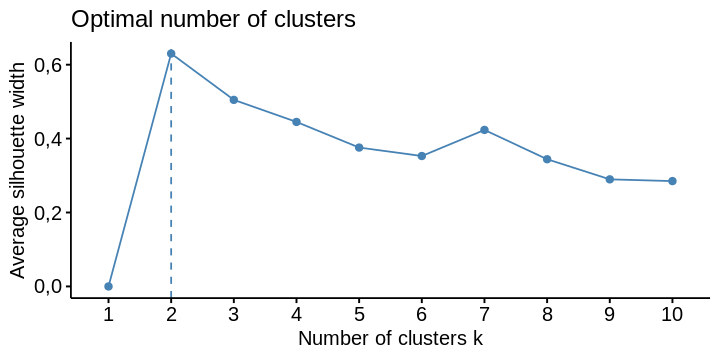

In [11]:
options(repr.plot.width=6, repr.plot.height=3)
fviz_nbclust(iris.new, kmeans, method = "silhouette")# +
#geom_vline(xintercept = 3, linetype = 2)

Auch wenn für $k = 2$ der höchste durchschnittliche Silhouettewert resultiert ist $k = 3$ die bessere Wahl (insbesondere, da wir bereits wissen, dass es drei Arten von Schwertlilien gibt, aber das wäre ja "Betrug", dieses Wissen zu verwenden). Denken Sie darüber nochmal nach, wenn Sie die Silhouetteplots in der Unterrichtsübung erzeugen.

Nun kann der k-Means-Algorithmus mit k=3 angewendet werden. Dieser ist im `stats`-Paket von R enthalten und steht somit direkt zur Verfügung.

In [12]:
result <- kmeans(iris.new, 3)

Zudem kann die Anzahl der durchlaufenen Iterationen bestimmt werden.

In [13]:
result$iter

[1] 2

Nun kann die Anzahl der Elemente bestimmt werden die pro Klasse gefunden wurden.

In [14]:
result$size

[1] 39 50 61

Außerdem können die Werte für die Zentroide herausgefunden werden. <br>
Hier muss aber beachtet werden, dass es sich um die normalisierten Werte handelt.

In [15]:
result$center

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
1,"0,7072650","0,4508547","0,79704476","0,82478632"
2,"0,1961111","0,5950000","0,07830508","0,06083333"
3,"0,4412568","0,3073770","0,57571548","0,54918033"


Allerdings können die Werte für die Zentroide auch auf die ursprünglich benutzten absoluten Werte umgewandelt werden.

In [16]:
result_old <- result$center
rdf = as.data.frame(result_old)

rdf$Sepal.Length <- max(iris$Sepal.Length) * rdf$Sepal.Length
rdf$Sepal.Width <- max(iris$Sepal.Width) * rdf$Sepal.Width
rdf$Petal.Length <- max(iris$Petal.Length) * rdf$Petal.Length
rdf$Petal.Width <- max(iris$Petal.Width) * rdf$Petal.Width
rdf

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
"5,587393","1,983761","5,4996089","2,0619658"
"1,549278","2,618000","0,5403051","0,1520833"
"3,485929","1,352459","3,9724368","1,3729508"


Zudem kann nun bei jedem Eintrag überprüft werden, zu welcher Klasse dieser zugeordnet wurde.

In [17]:
result$cluster

[1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 1 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [75] 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 1 1 1 1 3 1 1 1 1
[112] 1 1 3 1 1 1 1 1 3 1 3 1 3 1 1 3 3 1 1 1 1 1 3 3 1 1 1 3 1 1 1 3 1 1 1 3 1
[149] 1 3

Darüber hinaus kann nun die Homogenität innerhalb der einzelnen Cluster berechnet und ausgegeben werden. <br>Hierbei nutzt man die Summe der Fehlerquadrate. Diese sollten möglichst gering sein bei einer hohen Kompaktheit bzw. Homogenität.

In [18]:
round(result$withinss, 2)

[1] 2,07 1,83 3,08

In [19]:
round(result$tot.withinss, 2)

[1] 6,98

Das Berechnen der Heterogenität zwischen den Clustern ist ebenfalls möglich. Hier sollte die Zahl möglichst groß sein, da dies für eine hohe Unterschiedlichkeit der einzelnen Clustern spricht.

In [20]:
round(result$betweenss, 2)

[1] 34,18

Auch lässt sich die Summe von innerer Homogenität und äußerer Heterogenität einfach ausgeben.

In [21]:
round(result$totss, 2)

[1] 41,17

Zuletzt kann die Heterogenität zwischen den Clustern in Prozent berechnet und ausgegeben werden. Umso höher der Wert ist umso besser. Das Maximum liegt bei 100 %.

In [22]:
round(result$betweens / result$totss, 2)

[1] 0,83

## Visualisierung der Ergebnisse

Nun kann das Ergebnis noch geplottet werden und mit den Orginalklassen (Spezies) verglichen werden.

Dabei dient die Funktion `par` zum Einstellen von graphischen Parametern, wie z. B. dem Abstand durch `mar` oder die Dimensionen durch `mfrow`. Durch die Funktion `plot` werden die ausgewählten Punkte im Schaubild angezeigt und farblich gekennzeichnet.

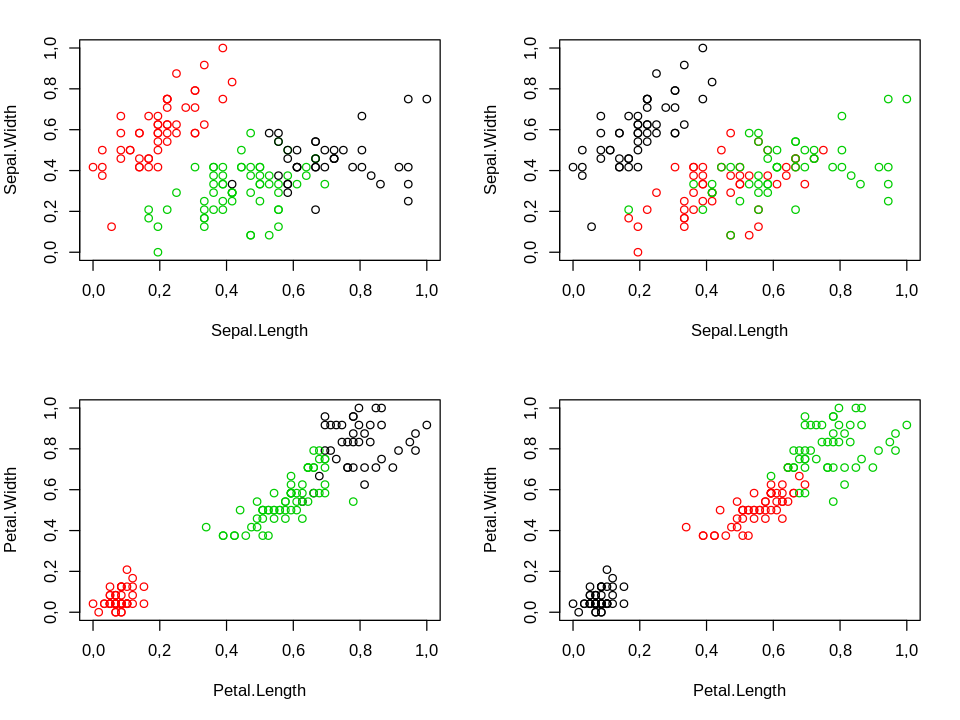

In [23]:
options(repr.plot.width=8, repr.plot.height=6)
par(mfrow=c(2,2), mar=c(5,4,2,2))
plot(iris.new[c(1,2)], col=result$cluster)
plot(iris.new[c(1,2)], col=iris.class)
plot(iris.new[c(3,4)], col=result$cluster)
plot(iris.new[c(3,4)], col=iris.class)

Natürlich stellt sich die Frage, ob unsere Einteilug in Cluster in der Lage war, die Zugehörigkeit zu den Spezies zu reproduzieren. Daher sehen wir uns die Einteilung der neuen Cluster in Bezug auf die vorhandenen Spezies in Tabellenform an (im Zusammenhang mit der Klassifikation werden wir hier von der *Konfusionsmatrix* sprechen).

In [24]:
table(result$cluster,iris.class)

   iris.class
    setosa versicolor virginica
  1      0          3        36
  2     50          0         0
  3      0         47        14

Das heißt Gruppe 1 entspricht Setosa, Gruppe 2 entspricht Virginica, Gruppe 3 entspricht Versicolor, wobei sich das Modell bezüglich der Klassen 2 und 3 nicht so ganz sicher ist. 

Im Einzelnen sehen wir:<br>
Anzahl richtig zugewiesener Examplare: 50+36+47 = 133. <br>
Anzahl falsch zugewiesener Examplare: 0+14+3 = 17.

Ein Übersicht über die Ergebnisse erhält man ganz einfach:

In [25]:
result

K-means clustering with 3 clusters of sizes 39, 50, 61

Cluster means:
  Sepal.Length Sepal.Width Petal.Length Petal.Width
1    0,7072650   0,4508547   0,79704476  0,82478632
2    0,1961111   0,5950000   0,07830508  0,06083333
3    0,4412568   0,3073770   0,57571548  0,54918033

Clustering vector:
  [1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 1 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [75] 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 1 1 1 1 3 1 1 1 1
[112] 1 1 3 1 1 1 1 1 3 1 3 1 3 1 1 3 3 1 1 1 1 1 3 3 1 1 1 3 1 1 1 3 1 1 1 3 1
[149] 1 3

Within cluster sum of squares by cluster:
[1] 2,073324 1,829062 3,079830
 (between_SS / total_SS =  83,0 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

### Weiterführende Analyse

Sieht man sich die Visualisierung der Ergebnisse nochmal an, so fällt auf, dass die Trennung der Spezies Versicolor und Virginica bei Betrachtung der Abmessungen des Sepalblatts schwer fällt, während diese dann, wenn man nur das Petalblatt betrachtet, gut getrennt zu sein scheinen. Daher stellt sich die Frage, ob das Clustering nicht mit *weniger Features* bessere Ergebnisse liefern würde?

Probieren Sie das mal aus ... (und verifizieren Sie damit nochmal die Ergebisse, die Sie in der Unterrichtsübung erhalten sollten).